# QuTiP example: Physical implementation of a spin chain qubit model

Following: https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/spin-chain-model.ipynb

In [1]:
from qutip.qip.circuit import QubitCircuit
from qutip.qip.operations import gate_sequence_product
import numpy as np
%matplotlib inline

In [11]:
import qutip
major, minor, patch = tuple(map(int, qutip.__version__.split('.')))
print(major, minor, patch)

4 5 1


In [13]:
if minor <= 4 and patch <=1:
    try:
        from qutip.qip.models.spinchain import CircularSpinChain
        from qutip.qip.models.spinchain import LinearSpinChain
    except ImportError as e:
        print(e)
else:
    try:
        from qutip.qip.device import CircularSpinChain, LinearSpinChain
        from qutip.qip.noise import RandomNoise
    except ImportError as e:
        print(e)

## Hamiltonian

$$
H = -\frac{1}{2} \sum_{n}^N h_n \sigma_z \left(n\right) - \frac{1}{2} \sum_{n}^{N-1}\left[ \sum_{j=x,y,z} \left( J_{j}^{(n)} \sigma_j \left(n\right) \sigma_j \left(n + 1\right) \right) \right]
$$

The linear and circular spin chain models employing nearest neighbor interactions may be implemented using the `SpinChain` class.

## Circuit Setup

In [14]:
N = 3
qc = QubitCircuit(N)
qc.add_gate('CNOT', targets=[0], controls=[2])

Non-adjacent interactions are broken into a series of adjacent ones by the program automatically.

In [15]:
U_ideal = gate_sequence_product(qc.propagators())
print(U_ideal)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


## Circular Spin Chain Model Implementation

In [18]:
p1 = CircularSpinChain(N, correct_global_phase=True)
U_list = p1.run(qc)
print(len(U_list))
print(U_list[-1])

12
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[0.70710678+0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j 0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.70710678j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.70710678+0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.70710678+0.70710678j 0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.       

In [19]:
U_physical = gate_sequence_product(U_list)
U_physical.tidyup(atol=1e-5)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]

In [20]:
(U_ideal - U_physical).norm()

0.0

The results from the physical implementation agree with the ideal result.

In [21]:
p1.qc0.gates

[Gate(CNOT, targets=[0], controls=[2])]

The gates are first converted to gates with adjacent interactions moving in the direction with the least number of qubits in between.

In [22]:
p1.qc1.gates

[Gate(CNOT, targets=[0], controls=[2])]

They are then converted into the basis \[ISWAP, RX, RZ\]:

In [23]:
p1.qc2.gates

[Gate(GLOBALPHASE, targets=None, controls=None),
 Gate(ISWAP, targets=[2, 0], controls=None),
 Gate(RZ, targets=[0], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(RX, targets=[2], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(ISWAP, targets=[2, 0], controls=None),
 Gate(RZ, targets=[0], controls=None),
 Gate(RX, targets=[0], controls=None),
 Gate(RZ, targets=[0], controls=None),
 Gate(RZ, targets=[0], controls=None)]

The time for each applied gate:

In [24]:
p1.get_full_tlist()

array([0.   , 1.25 , 1.375, 1.5  , 2.   , 2.125, 2.25 , 3.5  , 3.625,
       4.125, 4.25 , 4.375])

The pulses may be plotted:

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcab0fd12d0>)

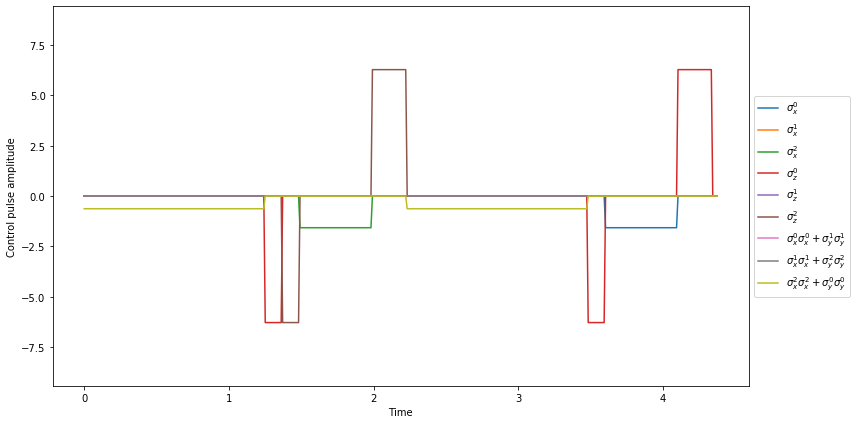

In [25]:
p1.plot_pulses()

## Linear Spin Chain Model Implementation

In [26]:
p2 = LinearSpinChain(N, correct_global_phase=True)
U_list = p2.run(qc)
print(len(U_list))
print(U_list[-1])

24
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[-0.70710678+0.70710678j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.70710678+0.70710678j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.70710678+0.70710678j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.70710678+0.70710678j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j         -0.70710678+0.70710678j  0.        +0.j
   0.        +0.j     

In [27]:
U_physical = gate_sequence_product(U_list)
U_physical.tidyup(atol=1e-5)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]

In [28]:
(U_ideal - U_physical).norm()

0.0

In [29]:
p2.qc0.gates

[Gate(CNOT, targets=[0], controls=[2])]

The gates are first converted to gates with adjacent interactions moving in the direction with the least number of qubits in between.

In [30]:
p2.qc1.gates

[Gate(SWAP, targets=[0, 1], controls=None),
 Gate(CNOT, targets=[1], controls=[2]),
 Gate(SWAP, targets=[0, 1], controls=None)]

They are then converted into the basis \[ISWAP, RX, RZ\].

In [31]:
p2.qc2.gates

[Gate(GLOBALPHASE, targets=None, controls=None),
 Gate(ISWAP, targets=[0, 1], controls=None),
 Gate(RX, targets=[0], controls=None),
 Gate(ISWAP, targets=[0, 1], controls=None),
 Gate(RX, targets=[1], controls=None),
 Gate(ISWAP, targets=[1, 0], controls=None),
 Gate(RX, targets=[0], controls=None),
 Gate(GLOBALPHASE, targets=None, controls=None),
 Gate(ISWAP, targets=[2, 1], controls=None),
 Gate(RZ, targets=[1], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(RX, targets=[2], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(RZ, targets=[2], controls=None),
 Gate(ISWAP, targets=[2, 1], controls=None),
 Gate(RZ, targets=[1], controls=None),
 Gate(RX, targets=[1], controls=None),
 Gate(RZ, targets=[1], controls=None),
 Gate(RZ, targets=[1], controls=None),
 Gate(GLOBALPHASE, targets=None, controls=None),
 Gate(ISWAP, targets=[0, 1], controls=None),
 Gate(RX, targets=[0], controls=None),
 Gate(ISWAP, targets=[0, 1], controls=None),
 Gate(RX, targets=[1], controls

The time for each applied gate:

In [32]:
p2.get_full_tlist()

array([ 0.   ,  1.25 ,  1.75 ,  3.   ,  3.5  ,  4.75 ,  5.25 ,  6.5  ,
        6.625,  6.75 ,  7.25 ,  7.375,  7.5  ,  8.75 ,  8.875,  9.375,
        9.5  ,  9.625, 10.875, 11.375, 12.625, 13.125, 14.375, 14.875])

The pulses may be plotted:

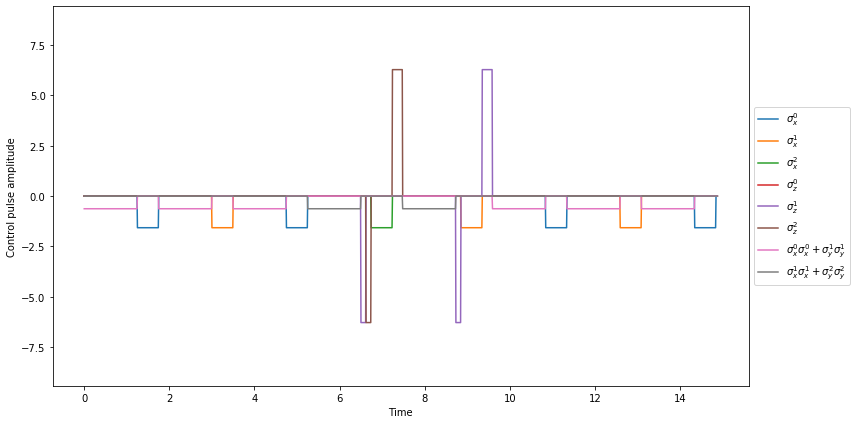

In [34]:
p2.plot_pulses();

## Numerical simulation